<a href="https://colab.research.google.com/github/JoelAbadi/DI-Bootcamp/blob/main/Mini_project_W9_D2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [2]:
def read_data() :
    """
      Reads and loads control and test group data from an Excel file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Control Group")
    #Average Bidding(New)
    test = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Test Group")

    #In the control dataframe, the rows containing NaN values from the 'note' column (imported from Excel) were removed
    control.drop(control.index[[30,31]], inplace = True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, dimension, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimension :
        for j in dimension :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [ ]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input

In [9]:
# TODO: Upload ZIP file
from google.colab import files
uploaded = files.upload()



Saving control_group.csv to control_group.csv
Saving test_group.csv to test_group.csv


In [24]:
# Define the read_data function
import pandas as pd
import os

def read_data():
    control_df = pd.read_csv(os.path.join("AB Test & Hypothesis Testing for E-commerce", "control_group.csv"), sep=';')
    test_df = pd.read_csv(os.path.join("AB Test & Hypothesis Testing for E-commerce", "test_group.csv"), sep=';')
    return control_df, test_df

In [12]:
control, test = read_data()

In [13]:
#TODO : print what is control

print("CONTROL DATA PREVIEW")
print(control.head())


CONTROL DATA PREVIEW
      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   
3  Control Campaign  4.08.2019         1940           72878.0   61235.0   
4  Control Campaign  5.08.2019         1835               NaN       NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
0          618.0  
1          511.0  
2 

In [14]:
#TODO : print what is test

print("TEST DATA PREVIEW")
print(test.head())


TEST DATA PREVIEW
   Campaign Name       Date  Spend [USD]  # of Impressions  Reach  \
0  Test Campaign  1.08.2019         3008             39550  35820   
1  Test Campaign  2.08.2019         2542            100719  91236   
2  Test Campaign  3.08.2019         2365             70263  45198   
3  Test Campaign  4.08.2019         2710             78451  25937   
4  Test Campaign  5.08.2019         2297            114295  95138   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 3038           1946               1069               894   
1                 4657           2359               1548               879   
2                 7885           2572               2367              1268   
3                 4216           2216               1437               566   
4                 5863           2106                858               956   

   # of Purchase  
0            255  
1            677  
2            578  
3            340  
4  

In [15]:
#TODO : check for null values in control

print("NULL VALUES IN CONTROL")
print(control.isnull().sum())


NULL VALUES IN CONTROL
Campaign Name          0
Date                   0
Spend [USD]            0
# of Impressions       1
Reach                  1
# of Website Clicks    1
# of Searches          1
# of View Content      1
# of Add to Cart       1
# of Purchase          1
dtype: int64


In [16]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).
#TODO :produces lists of column names for both categories for further use or reference.


kat_control = control.select_dtypes(include=['object'])     # Categorical
num_control = control.select_dtypes(include=['int64', 'float64'])  # Numerical

kat_columns = kat_control.columns.tolist()
num_columns = num_control.columns.tolist()

print("Categorical columns:", kat_columns)
print("Numerical columns:", num_columns)


Categorical columns: ['Campaign Name', 'Date']
Numerical columns: ['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [17]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
num_control_imputed = pd.DataFrame(imputer.fit_transform(num_control), columns=num_control.columns)

print("Nulls after imputation:\n", num_control_imputed.isnull().sum())


Nulls after imputation:
 Spend [USD]            0
# of Impressions       0
Reach                  0
# of Website Clicks    0
# of Searches          0
# of View Content      0
# of Add to Cart       0
# of Purchase          0
dtype: int64


In [18]:
# TODO : Combine categorical and numerical variables with the concept.

control = pd.concat([kat_control.reset_index(drop=True), num_control_imputed.reset_index(drop=True)], axis=1)
print("Control data after combining:", control.shape)


Control data after combining: (30, 10)


In [19]:
# Let's do a data type conversion.

control = convert_datatype(control)

print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [20]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     float64
 3   # of Impressions     30 non-null     int64  
 4   Reach                30 non-null     int64  
 5   # of Website Clicks  30 non-null     int64  
 6   # of Searches        30 non-null     int64  
 7   # of View Content    30 non-null     int64  
 8   # of Add to Cart     30 non-null     int64  
 9   # of Purchase        30 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

In [21]:
print("CONTROL:\n", control.describe(include='all'))
print("\nTEST:\n", test.describe(include='all'))


CONTROL:
            Campaign Name       Date  Spend [USD]  # of Impressions  \
count                 30         30    30.000000         30.000000   
unique                 1         30          NaN               NaN   
top     Control Campaign  1.08.2019          NaN               NaN   
freq                  30          1          NaN               NaN   
mean                 NaN        NaN  2288.433333     109186.466667   
std                  NaN        NaN   367.334451      21409.548580   
min                  NaN        NaN  1757.000000      71274.000000   
25%                  NaN        NaN  1945.500000      93612.000000   
50%                  NaN        NaN  2299.500000     112368.000000   
75%                  NaN        NaN  2532.000000     121259.000000   
max                  NaN        NaN  3083.000000     145248.000000   

                Reach  # of Website Clicks  # of Searches  # of View Content  \
count       30.000000            30.000000      30.000000          30

In [22]:
print("First rows of control group:")
print(control.head())

print("\nFirst rows of test group:")
print(test.head())


First rows of control group:
      Campaign Name       Date  Spend [USD]  # of Impressions   Reach  \
0  Control Campaign  1.08.2019       2280.0             82702   56930   
1  Control Campaign  2.08.2019       1757.0            121040  102513   
2  Control Campaign  3.08.2019       2343.0            131711  110862   
3  Control Campaign  4.08.2019       1940.0             72878   61235   
4  Control Campaign  5.08.2019       1835.0             98361   78445   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0                 7016           2290               2159              1819   
1                 8110           2033               1841              1219   
2                 6508           1737               1549              1134   
3                 3065           1042                982              1183   
4                 5762           2137               1931              1314   

   # of Purchase  
0            618  
1            511  
2     

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [27]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?

control, test = feature_engineering(control, test)

#TODO : Prepare and generate features for visualization with the help of a function

# Add group labels
control["Group"] = "Control"
test["Group"] = "Test"

# Combine into a single dataframe
AB = pd.concat([control, test], axis=0).reset_index(drop=True)



Let's look at the numbers A and B.

In [26]:
AB["Group"].value_counts()

,count
Group,
Control,30
Test,30


### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

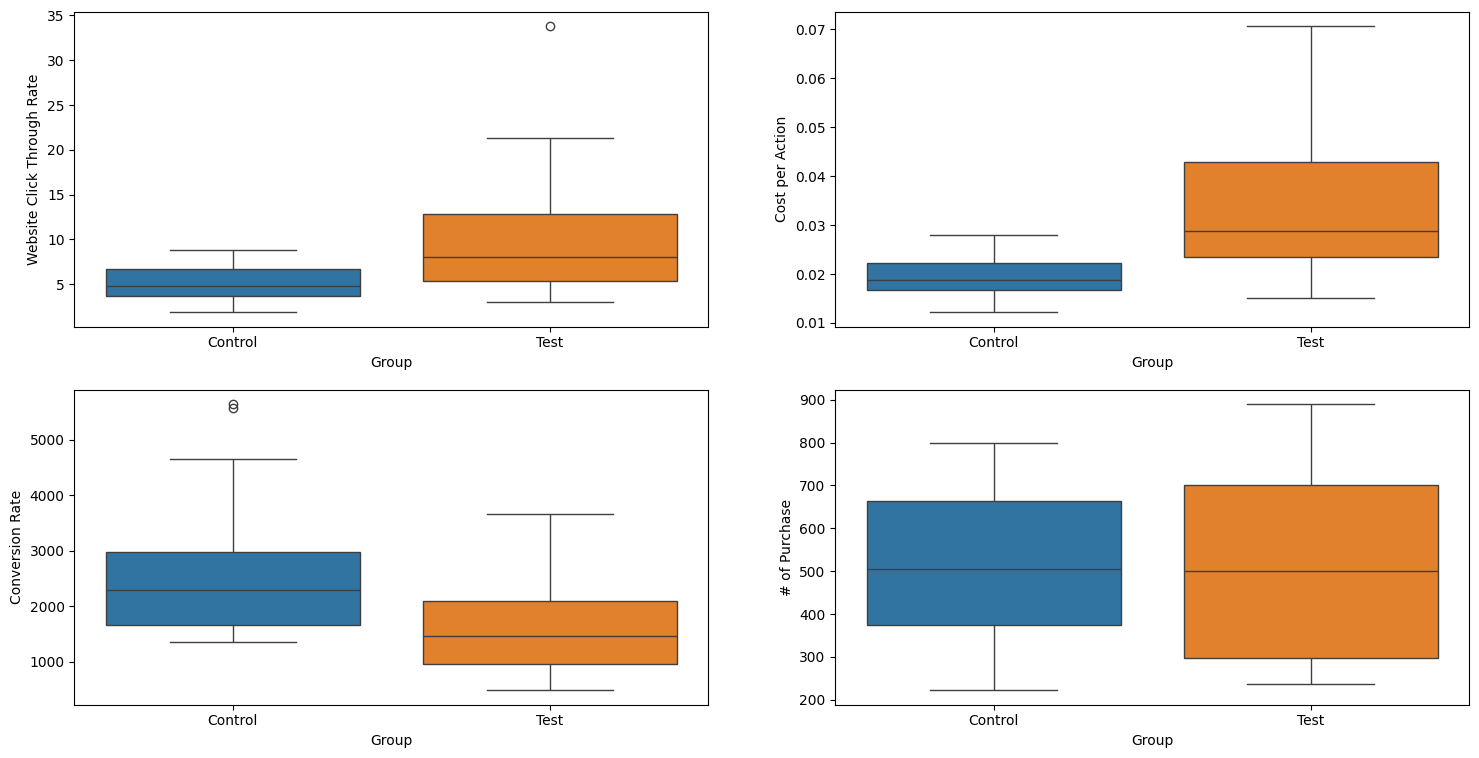

In [28]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [29]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.


AB_test_df = AB[["Group", "Website Click Through Rate", "Cost per Action", "Conversion Rate", "# of Purchase"]]
print(AB_test_df.head(3))



     Group  Website Click Through Rate  Cost per Action  Conversion Rate  \
0  Control                    8.483471         0.023602      1376.909920   
1  Control                    6.700264         0.013039      1661.578298   
2  Control                    4.941121         0.016383      2197.464659   

   # of Purchase  
0            618  
1            511  
2            372  


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [31]:
#TODO : Aply the normality assumption of the dataframe for A

from scipy.stats import shapiro

# Use the correct DataFrame name: AB
group_A = AB[AB["Group"] == "Control"]["# of Purchase"]

stat_A, p_value_A = shapiro(group_A)

print("Group A - Shapiro-Wilk Test Statistic:", round(stat_A, 3))
print("Group A - P-Value:", round(p_value_A, 3))



Group A - Shapiro-Wilk Test Statistic: 0.944
Group A - P-Value: 0.117


In [32]:
def checkReject(p_value, alpha=0.05):
    return "Reject H0 (Not Normal)" if p_value < alpha else "Fail to Reject H0 (Normal)"


In [33]:
print("Group A Normality Conclusion:", checkReject(p_value_A))


Group A Normality Conclusion: Fail to Reject H0 (Normal)


In [ ]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Does the HO hypothesis get rejected ? why ?

No, the H0 hypothesis does not get rejected because the p-value is 0.117, which is greater than 0.05. This means there is not enough evidence to reject the null hypothesis, so we assume that the data comes from a normal distribution.



In [34]:
#TODO : Aply the normality assumption of the dataframe for B

group_B = AB[AB["Group"] == "Test"]["# of Purchase"]

stat_B, p_value_B = shapiro(group_B)

print("Group B - Shapiro-Wilk Test Statistic:", round(stat_B, 3))
print("Group B - P-Value:", round(p_value_B, 3))



Group B - Shapiro-Wilk Test Statistic: 0.918
Group B - P-Value: 0.024


In [35]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.

print("Group B Normality Conclusion:", checkReject(p_value_B))


#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

Group B Normality Conclusion: Reject H0 (Not Normal)


Does the HO hypothesis get rejected ? why ?

Yes, the H0 hypothesis does get rejected because the p-value is 0.024, which is less than 0.05. This means there is enough evidence to reject the null hypothesis, so we conclude that the data does not follow a normal distribution.

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [36]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe

from scipy.stats import levene

# Run Levene's test on the '# of Purchase' column for both groups
stat_levene, p_levene = levene(
    AB[AB["Group"] == "Control"]["# of Purchase"],
    AB[AB["Group"] == "Test"]["# of Purchase"]
)

# Print the results
print("Levene's Test Statistic:", round(stat_levene, 3))
print("Levene's Test P-Value:", round(p_levene, 3))


Levene's Test Statistic: 1.527
Levene's Test P-Value: 0.222


In [ ]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.


Conclude about the variances, are they homogeneous ?

No, the null hypothesis (H₀: Variances are homogeneous) is not rejected because the p-value (0.222) is greater than the significance level (0.05).
So, we assume the variances are equal (homogeneous) between Group A and Group B.

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [41]:
# Average Bidding in (Test Group)
from scipy.stats import mannwhitneyu

# Extract the purchase data for both groups
group_A = AB[AB["Group"] == "Control"]["# of Purchase"]
group_B = AB[AB["Group"] == "Test"]["# of Purchase"]

# Run the Mann-Whitney U test
stat, p_value = mannwhitneyu(group_A, group_B)

# Print the results
print("Mann-Whitney U Test Statistic:", round(stat, 3))
print("P-Value:", round(p_value, 3))

# Conclusion based on p-value
def checkReject(p_value, alpha=0.05):
    return "Reject H₀ (Significant Difference)" if p_value < alpha else "Fail to Reject H₀ (No Significant Difference)"

print("Conclusion:", checkReject(p_value))


Mann-Whitney U Test Statistic: 456.0
P-Value: 0.935
Conclusion: Fail to Reject H₀ (No Significant Difference)


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?

No, the H₀ hypothesis should not be rejected because the p-value is 0.935, which is much higher than the significance level of 0.05. This means there is no statistically significant difference between the purchasing behavior of the Control and Test groups. Therefore, we conclude that the change implemented in the Test Group did not have a meaningful effect on the number of purchases.

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**


   
**2. Can we conclude statistically significant results?**

  


**3. Which statistical test did you use, and why?**
   
    
**4. Based on your answer to Question 2, what would be your recommendation to client?**

   

1. How would you define the hypothesis of this A/B test?

H₀ (Null Hypothesis): There is no statistically significant difference in the number of purchases between the Control group and the Test group (μ₁ = μ₂).

H₁ (Alternative Hypothesis): There is a statistically significant difference in the number of purchases between the Control group and the Test group (μ₁ ≠ μ₂)

2. Can we conclude statistically significant results?

No, we cannot conclude statistically significant results. The p-value from the Mann-Whitney U Test was 0.935, which is much higher than the significance threshold of 0.05. This indicates there is no significant difference in performance between the Control and Test groups.

3. Which statistical test did you use, and why?

I used the Mann-Whitney U Test, a nonparametric test for comparing two independent samples. This test was chosen because the normality assumption was violated for the Test group (as revealed by the Shapiro-Wilk test). The Mann-Whitney U Test does not assume a normal distribution and is appropriate for comparing medians in such cases.

4. Based on your answer to Question 2, what would be your recommendation to the client?

Since there is no statistically significant difference in the performance between the Control and Test groups, I recommend not rolling out the changes made in the Test group at this time. The new implementation did not lead to improved purchasing behavior, and maintaining the current version (Control) would be more stable and cost-effective until further tests are conducted.